In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('darkgrid', {'font.size': '20.'})

from zoobot.active_learning.analysis import smooth_loss
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline

In [7]:
os.chdir('/home/walml/repos/zoobot')

In [92]:
def load_tensorboard_metric(results_dir, run_name, n_iterations, model_n, eval_metric=False, frac=0.01, metric_name='loss'):

    dfs = []
    steps_since_iteration_1_start = 0
    for iteration_n in np.arange(1, n_iterations+1):
        log_name = '{}_iteration_{}_estimators_models_model_{}_log_tensorboard_validation-tag-epoch_loss.csv'.format(run_name, iteration_n, model_n)
        loc = os.path.join(results_dir, log_name)
        iteration_df = pd.read_csv(loc, usecols=['Step', 'Value'])
        iteration_df['iteration'] = iteration_n 
        iteration_df['iteration_step'] = iteration_df['Step']
        iteration_df['global_step'] = iteration_df['iteration_step'] + steps_since_iteration_1_start 
        steps_since_iteration_1_start = iteration_df['global_step'].max()

        smoothed_metric = sm.nonparametric.lowess(
            iteration_df['Value'],
            iteration_df['iteration_step'],
            is_sorted=True, 
            frac=frac)  # controls how much smoothing
        iteration_df['smoothed_{}'.format(metric_name)] = smoothed_metric[:, 1]

        
        dfs.append(iteration_df)
        
    flat_df = pd.concat(dfs)
    flat_df[metric_name] = flat_df['Value']
    del flat_df['Value']
    del flat_df['Step'] 
    flat_df['run_name'] = run_name
    if ('active' in run_name) or ('mutual' in run_name):
        flat_df['acquisition'] = 'active'
    else:
        flat_df['acquisition'] = 'baseline'

    return flat_df

In [93]:


results_dir = 'results/al_experiment_gz2_m2_3it_partialq'

save_dir = 'results/temp'

n_iterations = 3

In [94]:
eval_loss_frac = 0.015

In [114]:
active_eval_dfs = []
run_name = 'run-latest_dirichlet_unfiltered_active_m3_warm'
for model_n in range(2):
        active_eval_dfs.append(load_tensorboard_metric(results_dir, run_name, n_iterations, model_n, eval_metric=True, frac=eval_loss_frac))
        
baseline_eval_dfs = []
run_name = 'run-latest_dirichlet_unfiltered_baseline_m3_warm'
for model_n in range(2):
        baseline_eval_dfs.append(load_tensorboard_metric(results_dir, run_name, n_iterations, model_n, eval_metric=True, frac=eval_loss_frac))
        

eval_dfs = active_eval_dfs

In [115]:
active_eval_dfs[0]

,iteration,iteration_step,global_step,smoothed_loss,loss,run_name,acquisition
0,1,0,0,1.983402,1.983402,run-latest_dirichlet_unfiltered_active_m3_warm,active
1,1,1,1,1.969636,1.969636,run-latest_dirichlet_unfiltered_active_m3_warm,active
2,1,2,2,1.968154,1.968154,run-latest_dirichlet_unfiltered_active_m3_warm,active
3,1,3,3,1.970844,1.970844,run-latest_dirichlet_unfiltered_active_m3_warm,active
4,1,4,4,1.964399,1.964399,run-latest_dirichlet_unfiltered_active_m3_warm,active
...,...,...,...,...,...,...,...
15,3,15,56,1.953213,1.953213,run-latest_dirichlet_unfiltered_active_m3_warm,active
16,3,16,57,1.966054,1.966054,run-latest_dirichlet_unfiltered_active_m3_warm,active
17,3,17,58,1.956563,1.956563,run-latest_dirichlet_unfiltered_active_m3_warm,active
18,3,18,59,1.957110,1.957110,run-latest_dirichlet_unfiltered_active_m3_warm,active


In [102]:

eval_loss_df = pd.concat(eval_dfs).sort_values('global_step').reset_index()
active_eval_loss_g = eval_loss_df[eval_loss_df['acquisition'] == 'active'].groupby('global_step').agg('mean').reset_index()
# baseline_eval_loss_g = eval_loss_df[eval_loss_df['acquisition'] == 'baseline'].groupby('step').agg('mean').reset_index()

In [103]:
active_eval_loss_g

,global_step,index,iteration,iteration_step,smoothed_loss,loss
0,0,0.0,1.0,0.0,1.983402,1.983402
1,1,1.0,1.0,1.0,1.969636,1.969636
2,2,2.0,1.0,2.0,1.968154,1.968154
3,3,3.0,1.0,3.0,1.970844,1.970844
4,4,4.0,1.0,4.0,1.964399,1.964399
...,...,...,...,...,...,...
56,56,15.0,3.0,15.0,1.953213,1.953213
57,57,16.0,3.0,16.0,1.966054,1.966054
58,58,17.0,3.0,17.0,1.956563,1.956563
59,59,18.0,3.0,18.0,1.957110,1.957110


In [104]:
iteration_changes = active_eval_loss_g.groupby('iteration').agg({'global_step': 'min'}).reset_index()
iteration_changes

,iteration,global_step
0,1.0,0
1,1.5,25
2,2.0,26
3,2.5,41
4,3.0,42


Text(0, 0.5, 'Loss (Smoothed)')

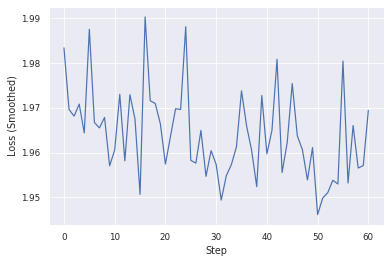

In [105]:
fig, ax = plt.subplots()
ax.plot(active_eval_loss_g['global_step'], active_eval_loss_g['loss'], label='Active')
# ax.plot(baseline_eval_loss_g['step'], baseline_eval_loss_g['smoothed_loss'], label='Baseline')
ax.set_xlabel('Step')
ax.set_ylabel('Loss (Smoothed)')
# if question == 'smooth':
#     ax.set_ylim([20, 25])
# if question == 'bar':
#     ax.set_ylim([10, 18])
# for step in acq_steps:
#     ax.axvline(step, alpha=0.2, color='k')
# ax.legend()

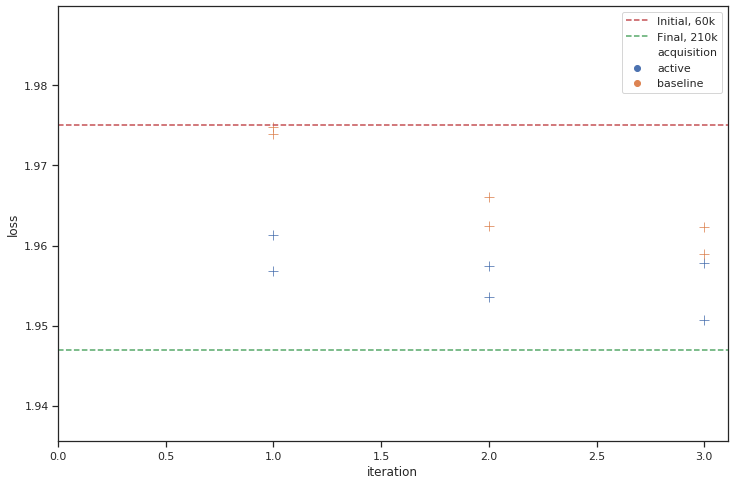

In [154]:
sns.set_style('ticks')
sns.set_context('notebook')
def mean_of_lowest_n(x, n=5):
    return np.sort(x)[:5].mean()

fig, ax = plt.subplots(figsize=(12, 8))

loss_values = []
for n, df in enumerate(active_eval_dfs):
    losses = df.query('iteration_step > 2').groupby('iteration').agg({'loss': mean_of_lowest_n}).reset_index()
    losses['acquisition'] = 'active'
    losses['model_n'] = n
    loss_values.append(losses)
    
for n, df in enumerate(baseline_eval_dfs):
    losses = df.query('iteration_step > 2').groupby('iteration').agg({'loss': mean_of_lowest_n}).reset_index()
    losses['acquisition'] = 'baseline'
    losses['model_n'] = n
    loss_values.append(losses)
    
loss_values = pd.concat(loss_values)
    
loss_values['galaxies'] = 58531+13653*loss_values['iteration']
# sns.lineplot(data=loss_values, x='iteration', y='loss', hue='acquisition')
sns.scatterplot(data=loss_values, x='iteration', y='loss', hue='acquisition', marker='+', s=100)
ax.axhline(1.975, color='r', linestyle='--', label='Initial, 60k')  # iteration 0 stable val loss by eye. 58,531 galaxies train, 15,000 eval, 110,297 pool, acquire 13,653 (10 shards, top third) per iter
ax.axhline(1.947, color='g', linestyle='--', label='Final, 210k')  # iteration 0 stable val loss by eye. 209,294 galaxies
ax.set_xlim([0., None])
plt.legend()

   iteration      loss
0          1  1.973970
1          2  1.966073
2          3  1.962374
   iteration      loss
0          1  1.974752
1          2  1.962462
2          3  1.958952
